In [1]:
!pip install -q transformers[torch]
!pip install -q -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

dataset = load_dataset("xtreme", "PAN-X.de")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [3]:
from collections import defaultdict
from datasets import DatasetDict

panx_ch = defaultdict(DatasetDict)

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

for lang, frac in zip(langs, fracs):
    ds = load_dataset("xtreme", f"PAN-X.{lang}")
    for split in ds.keys():
        panx_ch[lang][split] = (
            ds[split].shuffle(seed=0).select(range(int(frac * ds[split].num_rows)))
        )

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs}, index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [5]:
panx_ch["de"]["train"][0]

{'tokens': ['2.000',
  'Einwohnern',
  'an',
  'der',
  'Danziger',
  'Bucht',
  'in',
  'der',
  'polnischen',
  'Woiwodschaft',
  'Pommern',
  '.'],
 'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
 'langs': ['de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de']}

In [6]:
panx_ch["de"]["train"].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [7]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [8]:
tags.str2int("B-PER")

1

In [9]:
tags.int2str(1)

'B-PER'

In [10]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [11]:
de_example = panx_de["train"][0]
df = pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ["Tokens", "Tags"])
df

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [12]:
from itertools import chain
from collections import Counter

split2freqs = {}

for split in panx_de.keys():
    tag_names = []
    for row in panx_de[split]["ner_tags_str"]:
        tag_names.append([t.split("-")[1] for t in row if t.startswith("B")])
    split2freqs[split] = Counter(chain.from_iterable(tag_names))

pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


In [13]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [14]:
text = "Jack Sparrow is loving New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlm_tokens = xlmr_tokenizer(text).tokens()

In [15]:
print(f"BERT: {bert_tokens}")
print(f"XLM-R: {xlm_tokens}")

BERT: ['[CLS]', 'Jack', 'Spa', '##rrow', 'is', 'loving', 'New', 'York', '!', '[SEP]']
XLM-R: ['<s>', '▁Jack', '▁Spar', 'row', '▁is', '▁lo', 'ving', '▁New', '▁York', '!', '</s>']


In [16]:
"".join(xlm_tokens).replace("_", " ")

'<s>▁Jack▁Sparrow▁is▁loving▁New▁York!</s>'

In [17]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.models.roberta.modeling_roberta import (
    RobertaModel, RobertaPreTrainedModel
)

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        pass

In [18]:
from transformers.modeling_outputs import TokenClassifierOutput

def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
    outputs = self.roberta(input_ids, attention_mask=attention_mask,
                           token_type_ids=token_type_ids, **kwargs)
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)
    loss = None
    if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    return TokenClassifierOutput(loss=loss, logits=logits,
                                 hidden_states=outputs.hidden_states,
                                 attentions=outputs.attentions)

In [19]:
XLMRobertaForTokenClassification.forward = forward

In [20]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [21]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag,
                                         label2id=tag2index)

In [22]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlmr_model = XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
df = pd.DataFrame([xlmr_tokenizer.all_special_tokens, xlmr_tokenizer.all_special_ids], index=["Special Token", "Special Token ID"])
df

,0,1,2,3,4
Special Token,<s>,</s>,<unk>,<pad>,<mask>
Special Token ID,0,2,3,1,250001


In [24]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt").to(device)

In [25]:
outputs = xlmr_model(input_ids).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlm_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 11
Shape of outputs: torch.Size([1, 11, 7])


In [26]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
df = pd.DataFrame([xlm_tokens, preds], index=["Tokens", "Tags"])

In [27]:
!pip install -q hhpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.6 MB/s eta 0:00:00


In [28]:
from hhpy.ipython import display_df

display_df(df)

,0,1,2,3,4,5,6,7,8,9,10
Tokens,<s>,▁Jack,▁Spar,row,▁is,▁lo,ving,▁New,▁York,!,</s>
Tags,O,B-ORG,O,O,O,O,O,B-ORG,O,O,O


In [29]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [30]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['<s>',
 '▁2.000',
 '▁Einwohner',
 'n',
 '▁an',
 '▁der',
 '▁Dan',
 'zi',
 'ger',
 '▁Buch',
 't',
 '▁in',
 '▁der',
 '▁polni',
 'schen',
 '▁Wo',
 'i',
 'wod',
 'schaft',
 '▁Po',
 'mmer',
 'n',
 '▁',
 '.',
 '</s>']

In [31]:
word_ids = tokenized_input.word_ids()

In [32]:
print(word_ids)

[None, 0, 1, 1, 2, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, None]


In [33]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    else:
        label_ids.append(-100)
    previous_word_idx = word_idx

In [34]:
print(previous_word_idx)

None


In [35]:
print(label_ids)

[-100, 0, 0, -100, 0, 0, 5, -100, -100, 6, -100, 0, 0, 5, -100, 5, -100, -100, -100, 6, -100, -100, 0, -100, -100]


In [36]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []

    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [37]:
single_sample = panx_de["train"].select(range(1))
single_sample_encoded = single_sample.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [38]:
print(" ".join(token for token in single_sample[0]["tokens"]))
print(xlmr_tokenizer.decode(single_sample_encoded["input_ids"][0]))

2.000 Einwohnern an der Danziger Bucht in der polnischen Woiwodschaft Pommern .
<s> 2.000 Einwohnern an der Danziger Bucht in der polnischen Woiwodschaft Pommern.</s>


In [39]:
original_labels = single_sample["ner_tags_str"][0]
reconstructed_labels = [index2tag[idx] for idx in single_sample_encoded["labels"][0] if idx != -100]

In [40]:
df = pd.DataFrame([original_labels, reconstructed_labels])
display_df(df)

,0,1,2,3,4,5,6,7,8,9,10,11
0,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O
1,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [41]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=["langs", "ner_tags", "tokens"])

In [42]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])
panx_de_encoded

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
})

In [43]:
!pip install -q seqeval
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [44]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list



In [45]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size

training_args = TrainingArguments(
    output_dir="results",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps
)

In [46]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [47]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [48]:
from transformers import Trainer

trainer = Trainer(
    model=xlmr_model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_de_encoded["train"],
    eval_dataset=panx_de_encoded["validation"],
    tokenizer=xlmr_tokenizer
)

In [49]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.254200,0.151774,0.818894
2,0.126900,0.145221,0.842818
3,0.077900,0.141694,0.864227


TrainOutput(global_step=1575, training_loss=0.15285428855154248, metrics={'train_runtime': 488.9603, 'train_samples_per_second': 77.184, 'train_steps_per_second': 3.221, 'total_flos': 862324400720376.0, 'train_loss': 0.15285428855154248, 'epoch': 3.0})

In [50]:
trainer.save_model("models/xlm-roberta-base-finetuned-panx-de")

In [51]:
def tag_text(text, tags, model, tokenizer):
    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(text)))
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)
    outputs = model(inputs)[0]
    predictions = torch.argmax(outputs, dim=2)
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    df = pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])
    display_df(df)

In [52]:
text_de = "Mein Name ist Anna. Ich komme aus Österreich und lebe seit drei Jahren in Deutschland."

tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Tokens,<s>,▁Mein,▁Name,▁ist,▁Anna,.,▁Ich,▁komme,▁aus,▁Österreich,▁und,▁le,be,▁seit,▁drei,▁Jahren,▁in,▁Deutschland,.,</s>
Tags,O,O,O,O,B-PER,O,O,O,O,B-LOC,O,O,O,O,O,O,O,B-LOC,O,O


In [53]:
xlmr_model = XLMRobertaForTokenClassification.from_pretrained("models/xlm-roberta-base-finetuned-panx-de").to(device)

In [54]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        output = xlmr_model(input_ids, attention_mask)
        batch["predicted_label"] = torch.argmax(output.logits, axis=-1)

    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none")
    loss = loss.view(len(input_ids), -1)
    batch["loss"] = loss

    for k, v in batch.items():
        batch[k] = v.cpu().numpy()
    return batch

In [55]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
valid_set.set_format("pandas")
df = valid_set[:]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [57]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x)
)
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x]
)
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])


In [59]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float)

In [61]:
df_tokens.head()

,input_ids,attention_mask,labels,predicted_label,loss,input_tokens
0,10699,1,B-ORG,B-ORG,0.010898,▁Ham
0,15,1,I-ORG,I-ORG,0.009851,▁(
0,16104,1,I-ORG,I-ORG,0.010898,▁Unternehmen
0,1388,1,I-ORG,I-ORG,0.008678,▁)
1,56530,1,O,O,0.000154,▁WE


In [62]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="sum", ascending=True)
    .reset_index()
    .head(20)
)

,input_tokens,count,mean,sum
0,▁gerade,1,0.000081,0.000081
1,▁245,1,0.000082,0.000082
2,▁Dennoch,1,0.000084,0.000084
3,▁übernimmt,1,0.000085,0.000085
4,▁geschafft,1,0.000085,0.000085
5,▁gezielt,1,0.000085,0.000085
6,▁dürfte,1,0.000086,0.000086
7,▁jede,1,0.000087,0.000087
8,▁nachhaltig,1,0.000087,0.000087
9,▁Ihren,1,0.000087,0.000087


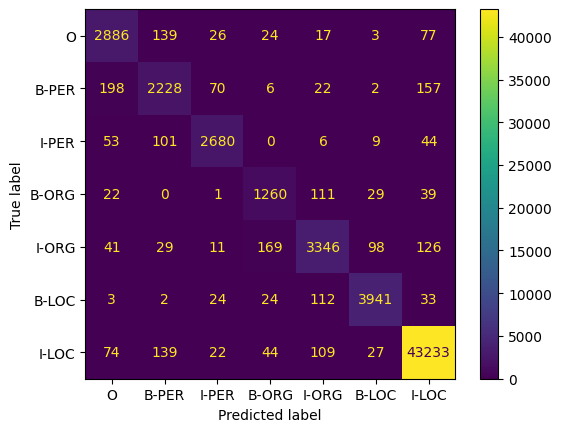

In [69]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(
    df_tokens["labels"], df_tokens["predicted_label"]
)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = tags.names)
cm_display.plot()
plt.show()

In [70]:
def display_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if mask == 1:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, "preds": preds, "losses": losses}).T
        display_df(df_tmp)
df["total_loss"] = df["loss"].apply(sum)
display_samples(df.sort_values(by="total_loss", ascending=True).head(3))

,0,1,2,3,4,5,6,7,8,9,10
tokens,<s>,▁Regi,e,▁führt,e,▁Daniel,▁Petri,e,▁,.,</s>
labels,IGN,O,IGN,O,IGN,B-PER,I-PER,IGN,O,IGN,IGN
preds,O,O,O,O,O,B-PER,I-PER,I-PER,O,O,O
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9
tokens,<s>,▁Rad,mila,▁Mano,jl,ović,▁2,▁,.,</s>
labels,IGN,B-PER,IGN,I-PER,IGN,IGN,O,O,IGN,IGN
preds,O,B-PER,B-PER,I-PER,I-PER,I-PER,O,O,O,O
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11
tokens,<s>,▁Regi,e,▁führt,e,▁Wolfgang,▁Sta,ud,te,▁,.,</s>
labels,IGN,O,IGN,O,IGN,B-PER,I-PER,IGN,IGN,O,IGN,IGN
preds,O,O,O,O,O,B-PER,I-PER,I-PER,I-PER,O,O,O
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [72]:
display_samples(df.loc[df["input_tokens"].apply(lambda x: "_(" in x)].head(3))

In [73]:
panx_de_encoded["validation"].reset_format()
preds_valid = trainer.predict(panx_de_encoded["validation"])


In [74]:
preds_valid.metrics

{'test_loss': 0.14169354736804962,
 'test_f1': 0.86422695035461,
 'test_runtime': 17.0516,
 'test_samples_per_second': 368.88,
 'test_steps_per_second': 15.424}

In [78]:
def generate_report(trainer, dataset):
    preds = trainer.predict(dataset)
    preds_list, label_list = align_predictions(
        preds.predictions, preds.label_ids
    )
    print(classification_report(label_list, preds_list, digits=4))
    return preds.metrics["test_f1"]

In [79]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = generate_report(trainer, panx_de_encoded["test"])

              precision    recall  f1-score   support

         LOC     0.8677    0.8909    0.8791      3180
         ORG     0.7877    0.7917    0.7897      2573
         PER     0.9166    0.9157    0.9161      3071

   micro avg     0.8613    0.8706    0.8659      8824
   macro avg     0.8573    0.8661    0.8616      8824
weighted avg     0.8614    0.8706    0.8659      8824



In [77]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,B-LOC,I-LOC,O


In [80]:
def evaluate_zero_shot_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return generate_report(trainer, panx_ds["test"])

In [81]:
f1_scores["de"]["fr"] = evaluate_zero_shot_performance("fr", trainer)

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

         LOC     0.7377    0.7168    0.7271      1130
         ORG     0.6291    0.6554    0.6419       885
         PER     0.7299    0.7656    0.7473      1045

   micro avg     0.7028    0.7157    0.7092      3060
   macro avg     0.6989    0.7126    0.7055      3060
weighted avg     0.7036    0.7157    0.7094      3060



In [82]:
f1_scores["de"]["fr"] = evaluate_zero_shot_performance("it", trainer)

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

         LOC     0.7333    0.6972    0.7148       426
         ORG     0.5216    0.6272    0.5696       346
         PER     0.7388    0.8204    0.7775       362

   micro avg     0.6631    0.7152    0.6882      1134
   macro avg     0.6646    0.7149    0.6873      1134
weighted avg     0.6705    0.7152    0.6905      1134



In [83]:
f1_scores["de"]["en"] = evaluate_zero_shot_performance("en", trainer)

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

         LOC     0.4885    0.6007    0.5388       283
         ORG     0.5773    0.6630    0.6172       276
         PER     0.6560    0.7008    0.6777       264

   micro avg     0.5681    0.6537    0.6079       823
   macro avg     0.5739    0.6548    0.6112       823
weighted avg     0.5720    0.6537    0.6096       823



In [90]:
f1_scores

defaultdict(dict,
            {'de': {'de': 0.8659189539536719,
              'fr': 0.6881629189647858,
              'en': 0.607909604519774}})

In [84]:
def model_init():
    return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

In [87]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        tokenizer=xlmr_tokenizer
    )
    trainer.train()
    metrics = trainer.predict(test_ds).metrics
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [metrics["test_f1"]]}
    )

In [88]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.611400,1.290540,0.023221
2,1.186100,0.994059,0.194721
3,0.996400,0.918272,0.258691


,num_samples,f1_score
0,250,0.260191


In [89]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True
    )

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.424700,1.023299,0.273481
2,0.868600,0.658805,0.558438
3,0.594300,0.569413,0.631595


<ipython-input-89-074b89c6f631>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.070700,0.547355,0.668593
2,0.452200,0.419030,0.719858
3,0.301100,0.392787,0.765788


<ipython-input-89-074b89c6f631>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.774600,0.424113,0.729323
2,0.321700,0.343038,0.776030
3,0.204100,0.331930,0.813378


<ipython-input-89-074b89c6f631>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.587900,0.336302,0.785022
2,0.274500,0.305499,0.821070
3,0.178800,0.284760,0.833779


<ipython-input-89-074b89c6f631>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(


In [91]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]
        ).shuffle(seed=42)
    return multi_corpus

panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [94]:
panx_de_fr_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 17160
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8580
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8580
    })
})

In [92]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size

trainer.train_dataset = panx_de_fr_encoded["train"]
trainer.eval_dataset = panx_de_fr_encoded["validation"]
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.153000,0.173053,0.840525
2,0.096900,0.178783,0.850892
3,0.057400,0.186074,0.863777


TrainOutput(global_step=2145, training_loss=0.10242025379812245, metrics={'train_runtime': 658.3148, 'train_samples_per_second': 78.2, 'train_steps_per_second': 3.258, 'total_flos': 1141065108882864.0, 'train_loss': 0.10242025379812245, 'epoch': 3.0})

In [96]:
corpora = [panx_de_encoded]

for lang in langs[1:]:
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    f1_scores[lang][lang] = metrics["f1_score"][0]
    corpora.append(ds_encoded)

corpora_encoded = concatenate_splits(corpora)



Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.564700,0.324170,0.772765
2,0.267100,0.267203,0.820195
3,0.174400,0.274962,0.849510


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.721700,0.319269,0.734277
2,0.273600,0.276007,0.805522
3,0.183800,0.261933,0.832099


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.047900,0.485380,0.585653
2,0.460400,0.399503,0.660460
3,0.379700,0.390541,0.686066


In [97]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
trainer.train_dataset = corpora_encoded["train"]
trainer.eval_dataset = corpora_encoded["validation"]
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.119900,0.191237,0.848604
2,0.076000,0.198787,0.857721
3,0.043500,0.223752,0.862480


TrainOutput(global_step=2505, training_loss=0.07974763689878696, metrics={'train_runtime': 752.61, 'train_samples_per_second': 79.802, 'train_steps_per_second': 3.328, 'total_flos': 1314051381280176.0, 'train_loss': 0.07974763689878696, 'epoch': 3.0})

In [98]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = (trainer.predict(corpora[idx]["test"]).metrics["test_f1"])
scores_data = {
    "de": f1_scores["de"],
    "each": {lang: f1_scores[lang][lang] for lang in langs},
    "all": f1_scores["all"]
}
f1_scores_df = pd.DataFrame.from_dict(scores_data, orient="index").round(4)